<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\TMS.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0       time   open   high    low  close  volume
0              0   5/1/2015  13.06  13.06  13.06  13.06      10
1              1   6/1/2015  13.96  13.96  12.69  12.69    2730
2              2   7/1/2015  13.56  13.56  13.54  13.56     350
3              3   8/1/2015  13.56  14.01  13.56  14.01    1410
4              4   9/1/2015  14.01  14.99  14.01  14.99     160
...          ...        ...    ...    ...    ...    ...     ...
2419        2419  13/9/2024  50.20  50.20  48.55  48.55    1900
2420        2420  16/9/2024  48.75  48.80  48.75  48.80    1000
2421        2421  17/9/2024  48.80  49.70  48.80  49.70     200
2422        2422  18/9/2024  48.05  49.90  48.05  49.90     400
2423        2423  19/9/2024  49.90  49.90  49.90  49.90    8500

[2424 rows x 7 columns]>

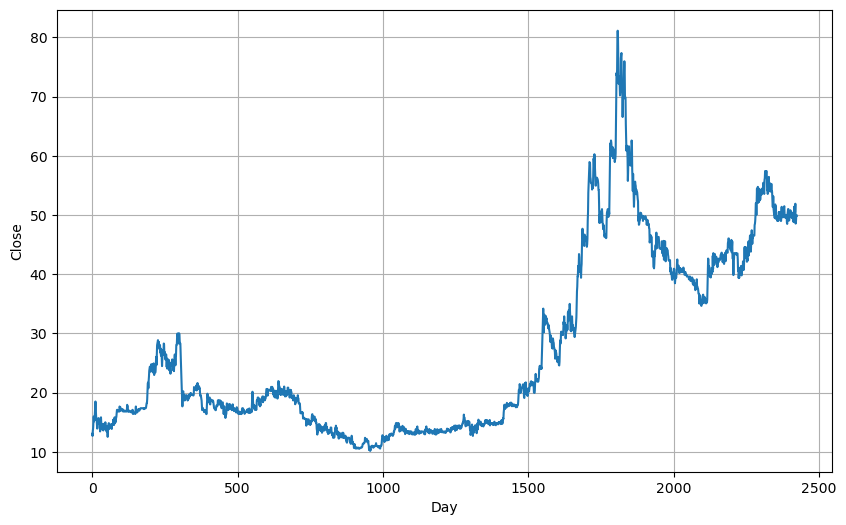

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\TMS.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
62/62 [==============================] - 4s 35ms/step - loss: 26.3010 - mae: 26.7954
Epoch 2/100
62/62 [==============================] - 1s 15ms/step - loss: 5.7125 - mae: 6.1907
Epoch 3/100
62/62 [==============================] - 1s 15ms/step - loss: 4.0178 - mae: 4.4892
Epoch 4/100
62/62 [==============================] - 1s 14ms/step - loss: 2.9536 - mae: 3.4084
Epoch 5/100
62/62 [==============================] - 1s 15ms/step - loss: 2.3640 - mae: 2.8116
Epoch 6/100
62/62 [==============================] - 1s 14ms/step - loss: 1.7728 - mae: 2.2063
Epoch 7/100
62/62 [==============================] - 1s 12ms/step - loss: 1.1155 - mae: 1.4885
Epoch 8/100
62/62 [==============================] - 1s 12ms/step - loss: 0.8702 - mae: 1.2377
Epoch 9/100
62/62 [==============================] - 1s 14ms/step - loss: 0.7128 - mae: 1.0584
Epoch 10/100
62/62 [==============================] - 1s 13ms/step - loss: 0.6396 - mae: 0.9764
Epoch 11/100
62/62 [===========================

62/62 [==============================] - 1s 18ms/step - loss: 0.2775 - mae: 0.5776
Epoch 87/100
62/62 [==============================] - 1s 14ms/step - loss: 0.2785 - mae: 0.5825
Epoch 88/100
62/62 [==============================] - 1s 12ms/step - loss: 0.2683 - mae: 0.5574
Epoch 89/100
62/62 [==============================] - 1s 14ms/step - loss: 0.3058 - mae: 0.6075
Epoch 90/100
62/62 [==============================] - 1s 16ms/step - loss: 0.3153 - mae: 0.6369
Epoch 91/100
62/62 [==============================] - 1s 14ms/step - loss: 0.2731 - mae: 0.5712
Epoch 92/100
62/62 [==============================] - 1s 13ms/step - loss: 0.2861 - mae: 0.5942
Epoch 93/100
62/62 [==============================] - 1s 13ms/step - loss: 0.3104 - mae: 0.6357
Epoch 94/100
62/62 [==============================] - 1s 14ms/step - loss: 0.4107 - mae: 0.7738
Epoch 95/100
62/62 [==============================] - 1s 14ms/step - loss: 0.3649 - mae: 0.7080
Epoch 96/100
62/62 [==============================] -

In [7]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

14/14 [==============================] - 1s 8ms/step


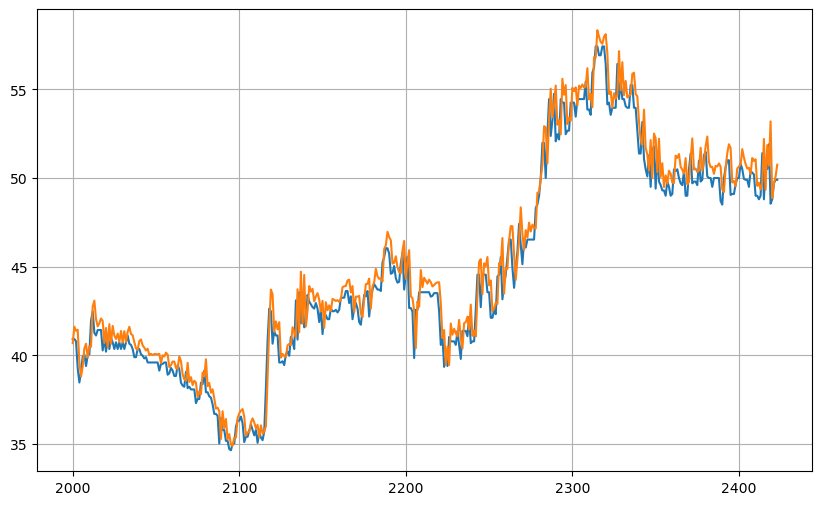

[40.69161  41.61826  41.38972  41.442688 39.628773 38.81017  39.356117
 40.394157 40.65942  39.88285  40.52105  40.48077  42.73901  43.091637
 42.04381  41.637836 41.814262 42.0784   41.942543 40.699142 41.545837
 40.460842 41.762943 40.652668 41.661972 41.116726 40.925262 41.230137
 40.7637   41.374916 40.71933  41.364883 40.763218 41.325314 41.614048
 41.207737 41.133183 40.746246 40.397053 40.312492 40.81498  40.89483
 40.562675 40.431797 40.2757   40.377693 40.020283 40.08711  40.01718
 40.080166 40.068443 40.061806 40.081795 39.56402  40.003986 39.931236
 40.155746 40.04468  39.339172 39.44595  39.65215  39.6535   39.283382
 39.237125 39.945637 39.675922 38.92798  38.65186  38.563705 39.5804
 38.50055  38.774384 38.325794 38.567345 38.468117 37.641876 37.977264
 37.80844  39.030178 38.805122 39.779144 38.265007 38.44382  37.899548
 38.08476  37.575073 37.001175 37.05083  36.859627 35.29055  36.851543
 35.91258  36.41258  35.267426 35.56285  34.96583  34.906612 35.364513
 35.366215

In [8]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)